In [188]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


In [720]:
%matplotlib inline
%connect_info

{
  "stdin_port": 39126, 
  "ip": "127.0.0.1", 
  "control_port": 35048, 
  "hb_port": 55538, 
  "signature_scheme": "hmac-sha256", 
  "key": "efc2e6f8-d4e4-408b-8886-5bdce55279e2", 
  "shell_port": 48489, 
  "transport": "tcp", 
  "iopub_port": 50378
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /run/user/1000/jupyter/kernel-ab4d6c52-57d2-4436-ad08-eef2f47274c6.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


Try to mask out HUD/UI elements by detection regions that slowly change from frame to frame

In [3]:
images = array(images)
diffs = images[1:] - images[:-1]
mask = std(diffs, 0)
thresh = 0.3;
mask = cv2.GaussianBlur(mask, (0,0), 2)
mask[mask < mask.max() * thresh] = 0
mask[mask >= mask.max() * thresh] = 1

imshow(mask)

NameError: name 'images' is not defined

In [128]:
import cv2

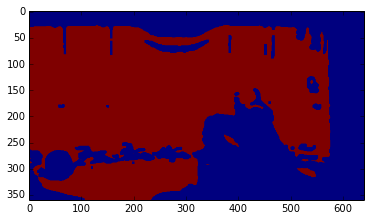

In [190]:
mask2 = cv2.medianBlur(array(mask, dtype=np.float32), 5)
mask2 = cv2.erode(mask2, ones((3,3)))
imshow(mask2)

In [53]:
imshow(images[4], cmap=cm.gray)
plot(points[:, 0], points[:, 1], 'r.')

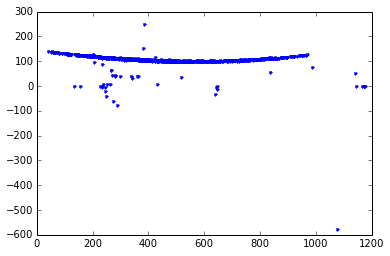

In [602]:
plot(mv[:,0], mv[:,2], '.')

In [1614]:
from sklearn import linear_model

X = np.vstack((mv[:, 0]**2, mv[:, 0], ones(mv.shape[0]))).T
y = mv[:, 2]

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(fit_intercept=False))
model_ransac.fit(X, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

a, b, c = model_ransac.estimator_.coef_
a, b, c

(2.9389954384692558e-05, -0.035636072284646048, 29.733696485112709)

In [1615]:
%matplotlib qt

X_in = mv[inlier_mask, 0]
X_out = mv[outlier_mask, 0]
y_in = mv[inlier_mask, 2]
y_out = mv[outlier_mask, 2]
plot(X_in, y_in, '.')
plot(X_out, y_out, '.')
t = linspace(X_in.min(), X_in.max(), 100)
plot(t, a*t**2 + b*t + c)
x_min = -b/(2*a)
a*x_min**2 + b*x_min + c

18.931283939195769

In [1672]:
control = [10e3, 15e3, 20e3,
           25e3, 26e3, 27e3, 28e3, 29e3, 29.5e3,
           30e3]
speed = [9.740644336872279/3, 36.030645952209511/3, 37.124312115088088, 
         101.34249310780383, 123.63380553013994, 80.687738743971806*2, 95.34390238190602*2, 110.64445509500386*2, 78.85052787064636*10,
         162.92974488164242*10]
plot(control, speed, '.-')

Populating the interactive namespace from numpy and matplotlib


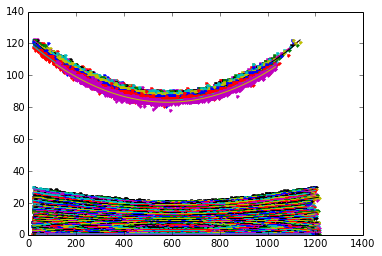

In [918]:
%pylab inline

from sklearn import linear_model
x_mins = []
y_mins = []
for idx in range(len(M)):
    mv = M[idx]
    s = S[idx]
    #plot(mv[:,0], mv[:,2], '.')
    
    X = np.vstack((mv[:, 0]**2, mv[:, 0], ones(mv.shape[0]))).T
    y = mv[:, 2] / s

    # Robustly fit linear model with RANSAC algorithm
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(fit_intercept=False))
    model_ransac.fit(X, y)
    inlier_mask = model_ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    a, b, c = model_ransac.estimator_.coef_
    a, b, c
    
    X_in = mv[inlier_mask, 0]
    X_out = mv[outlier_mask, 0]
    y_in = mv[inlier_mask, 2] / s
    y_out = mv[outlier_mask, 2] / s
    plot(X_in, y_in, '.')
    #plot(X_out, y_out, '.')
    t = linspace(X_in.min(), X_in.max(), 100)
    plot(t, a*t**2 + b*t + c)
    x_min = -b/(2*a)
    x_mins.append(x_min)
    y_mins.append(a*x_min**2 + b*x_min + c)
    
y_mins = array(y_mins)

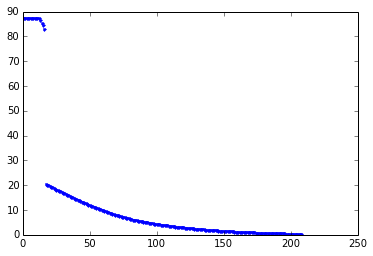

In [919]:
plot(y_mins, '.')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
avg diff is 0.000248035610017


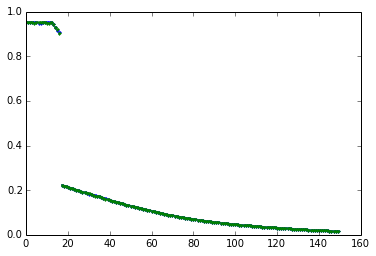

In [991]:
from scipy.optimize import minimize
import sys

def FrameDelta(X, rot_hz, epsilon, s=1, dt=1.0/60.0, w=1280, f=1280):
    X = X - w/2 + epsilon
    phi_dot = 2*pi * rot_hz

    Theta1 = arctan(X / f)
    Theta2 = Theta1 + s*dt*phi_dot
    return f*(tan(Theta2) - tan(Theta1))

def GetInliers(X, y):
    X = np.vstack((X**2, X, ones(X.shape[0]))).T

    # Robustly fit linear model with RANSAC algorithm
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(fit_intercept=False))
    model_ransac.fit(X, y)
    return model_ransac.inlier_mask_

class MinFun (object):
    def __init__(self, X, y, s):
        self.X = X
        self.y = y
        self.s = s
        
    def __call__(self, args):
        rot_hz = args[0]
        epsilon = args[1]
        f = args[2]
        y_hat = FrameDelta(self.X, rot_hz, epsilon, self.s, f=f)
        diff = y_hat - self.y
        #return diff.dot(diff)
        return sum(sqrt(abs(diff)))

thetas = []
for idx in xrange(len(M)):
#for idx in xrange(90,110):
    #idx = 90
    s = S[idx]
    X = M[idx][:, 0]
    y = M[idx][:, 2]
    W = 1280
    #inliers = GetInliers(X, y)
    #X_in = X[inliers]
    #y_in = y[inliers]
    X_in = X
    y_in = y

    minfun = MinFun(X_in, y_in, s)
    x0 = [sqrt(0.0577), 12, 870]
    res = minimize(lambda x: minfun([x[0], eps_hat, f_hat]), x0, method='Powell')
    #res = minimize(minfun, x0, method='Powell')

    #print '{} rot_hz={:.4f}, eps={:.4f}, f={:.4f}'.format(res.success, res.x[0], res.x[1], res.x[2])
    #print res
    
    if res.success:
        thetas.append([idx, s, res.x[0], res.x[1], res.x[2]])
        if idx % 10 == 0:
            print idx            
    else:
        print 'Fail at', idx

    #N = 200
    #t = linspace(0, W, N)
    #y_lin = FrameDelta(t, res.x[0], res.x[1], s, f=res.x[2])
    
    #plot(t, y_lin)
    #plot(X_in, y_in, '.')

thetas = array(thetas)

eps_hat = mean(thetas[:120,3])
f_hat = mean(thetas[:120,4])

N = 150
y_mins_norm = thetas[:N,2].max()*y_mins[:N]/y_mins.max()

plot(thetas[:N, 0], thetas[:N, 2], '.')
plot(y_mins_norm[:N], '.')

print 'avg diff is', sum(abs(thetas[:N, 2] - y_mins_norm[:N])) / N

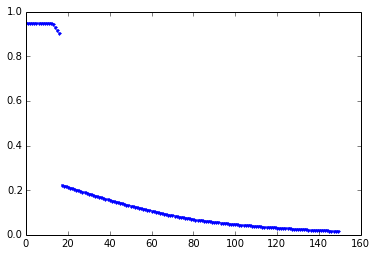

In [986]:
Np = 150
plot(thetas[:Np, 0], thetas[:Np, 2], '.')

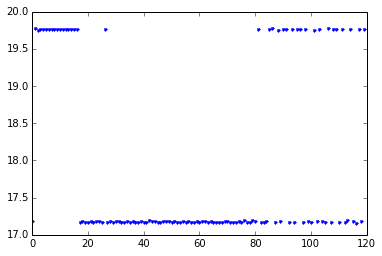

In [987]:
plot(thetas[:120,3],'.')

In [979]:
eps_hat = mean(thetas[:120,3])
f_hat = mean(thetas[:120,4])
eps_hat, f_hat

(11.521001283465795, 877.13848729296001)